# Setup

## Imports

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import json
import os
import pandas as pd

import torch.nn as nn
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import F1Score, Accuracy

import lightning as L
import numpy as np

from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

import lightning as L
import torch
from torch import nn
from torch.nn import functional as F
from torchmetrics import Accuracy, MetricCollection, F1Score

from utils import *

/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

In [21]:
class FC(L.LightningModule):
    def __init__(self, embedding_dim=768, hidden_dim=128, output_dim=1):
        super(FC, self).__init__()

        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.loss_fn = nn.BCEWithLogitsLoss()

        self.train_acc = F1Score(task="binary")
        self.val_acc = F1Score(task="binary")
        self.test_acc = F1Score(task="binary")

    def forward(self, x):
        # x = torch.mean(x, dim=1)  # average over the sequence length

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # no activation - BCEWithLogitsLoss applies sigmoid
        return x

    def _common_step(self, batch, batch_idx, acc_metric):
        x, y = batch['embeddings'], batch['label']
        logits = self(x).squeeze(-1)  # remove the last singleton dimension if it exists

        # Take the mean or max of logits across the sequence dimension
        # logits = logits.mean(dim=1)  # Mean aggregation
        logits = logits.max(dim=1).values  # Max aggregation

        loss = self.loss_fn(logits, y.type_as(logits))
        acc_metric.update(logits.sigmoid(), y)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx, self.train_acc)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True)
        self.log('train_acc', self.train_acc.compute(), on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx, self.val_acc)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True)
        self.log('val_acc', self.val_acc.compute(), on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx, self.test_acc)
        self.log('test_loss', loss, sync_dist=True)
        self.log('test_acc', self.test_acc.compute(), on_step=False, on_epoch=True, sync_dist=True)
        return loss

    def on_train_epoch_end(self):
        self.train_acc.reset()

    def on_validation_epoch_end(self):
        self.val_acc.reset()

    def on_test_epoch_end(self):
        self.test_acc.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

class Attention(nn.Module):
    def __init__(self, feature_size):
        super(Attention, self).__init__()
        self.query_projection = nn.Linear(feature_size, feature_size)
        self.key_projection = nn.Linear(feature_size, feature_size)
        self.value_projection = nn.Linear(feature_size, feature_size)

    def forward(self, query, keys, values):
        query_proj = self.query_projection(query)
        keys_proj = self.key_projection(keys)
        values_proj = self.value_projection(values)

        scores = torch.matmul(query_proj, keys_proj.transpose(-2, -1)) / (keys_proj.shape[-1] ** 0.5)
        weights = F.softmax(scores, dim=-1)

        attended = torch.matmul(weights, values_proj)
        return attended.squeeze(1), weights  # assume the query is batch-wise

class AttentionModel(L.LightningModule):
    def __init__(self, embedding_dim=768, hidden_dim=128, output_dim=1):
        super(AttentionModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # self.attention_layer = Attention(embedding_dim)
        self.attention_layer = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=5)

        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        self.loss_fn = nn.BCEWithLogitsLoss()

        self.accuracy = Accuracy(task="binary")

    def forward(self, x):
        # Assume x is [batch_size, seq_len, embedding_dim]
        # Apply attention
        query = x.mean(dim=1, keepdim=True)  # A simple way to obtain a query from inputs
        attended_features, _ = self.attention_layer(query, x, x)

        x = F.relu(self.fc1(attended_features))
        x = self.fc2(x)
        return x

    def _common_step(self, batch, batch_idx):
        x, y = batch['embeddings'], batch['label']
        logits = self(x).squeeze()
        loss = self.loss_fn(logits, y.type_as(logits))
        self.accuracy.update(logits.sigmoid(), y)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True)
        self.log('train_acc', self.accuracy.compute(), on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True)
        self.log('val_acc', self.accuracy.compute(), on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx)
        self.log('test_loss', loss, sync_dist=True)
        self.log('test_acc', self.accuracy.compute(), on_step=False, on_epoch=True, sync_dist=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

## Data Setup

In [2]:
with open("data/all_v2.json","r") as j_file:
    data = json.load(j_file)

train_dl, val_dl, test_dl, _ = load_data(data, batch_sizes=(30, 30, 20))


        train: 46431
        val: 9949
        test: 9951
        


In [10]:
_[0][0]

{'patient_id': 'c41321db-61bf-188a-7336-e74897c037fb',
 'label': False,
 'lat': 34.870726412407734,
 'lon': -82.48126845032735,
 'encounters': [{'encounter': {'Description': 'Well child visit',
    'ReasonDescription': ''},
   'conditions': [{'Description': 'Recurrent urinary tract infection'}],
   'careplans': [{'Description': '', 'ReasonDescription': ''}],
   'procedures': [{'Description': '', 'ReasonDescription': ''}]},
  {'encounter': {'Description': 'General examination of patient',
    'ReasonDescription': ''},
   'conditions': [{'Description': 'Received certificate of high school equivalency'},
    {'Description': 'Has a criminal record'}],
   'careplans': [{'Description': '', 'ReasonDescription': ''}],
   'procedures': [{'Description': '', 'ReasonDescription': ''}]},
  {'encounter': {'Description': 'General examination of patient',
    'ReasonDescription': ''},
   'conditions': [{'Description': 'Essential hypertension'},
    {'Description': 'Refugee'}],
   'careplans': [{'Descr

In [17]:
tmp = _[0]

counts = [[item['patient_id'], item['label'], len(item['encounters'])] for item in tmp]

df = pd.DataFrame(counts, columns=['patient_id', 'label', 'num_encounters'])
df

,patient_id,label,num_encounters
0,c41321db-61bf-188a-7336-e74897c037fb,False,798
1,843a93ff-26df-170f-b374-43cc1176b35a,False,42
2,0355144b-6af0-53ab-0d17-68d9e4a0f2ba,False,25
3,b3bf889a-6f89-68be-520a-53662f6aa2d1,True,38
4,927a2d26-a87c-b165-1d64-550d145ce647,False,20
...,...,...,...
46426,3cb972f3-96ce-11ce-3ecc-86ba5d4a6569,False,62
46427,520aae68-0887-1381-2422-c494a94c9101,False,99
46428,09e5ef00-20e8-9761-c672-6fc76d8cbbe7,False,30
46429,8edc1123-aeda-7c6f-7c5f-9b9f49056e12,False,40


In [41]:
df_true = df[df['label'] == True]

# Group by patient_id and get the row with the maximum number of encounters
result = df_true.loc[df_true.groupby('patient_id')['num_encounters'].idxmax()]

# Display the result
print(result)

                                 patient_id  label  num_encounters
39836  000f8736-804a-f4d0-a149-1fbe9cb9eb54   True             147
35809  00134bc4-34ae-3f6f-31d5-2092d173e799   True              22
17130  00198c87-e5bf-3315-f2df-452808829cbc   True              39
14864  0019c6ca-67ba-050e-9bf8-530668860f2e   True              14
35033  001cd51f-938f-24cb-714e-6be2cf0db894   True              25
...                                     ...    ...             ...
29154  ffbe3ec0-976c-a03d-7fe7-ec3235817116   True             219
40209  ffc58033-06d0-8233-d13b-3010929852b4   True             381
28933  ffd05748-68ba-2dd6-40f2-3d9a28c3ef83   True              23
12771  fff7932b-6954-1789-c7a0-a67df8e25420   True              43
19040  fff8725e-53df-c967-c35a-b40c5f0c248e   True              32

[5756 rows x 3 columns]


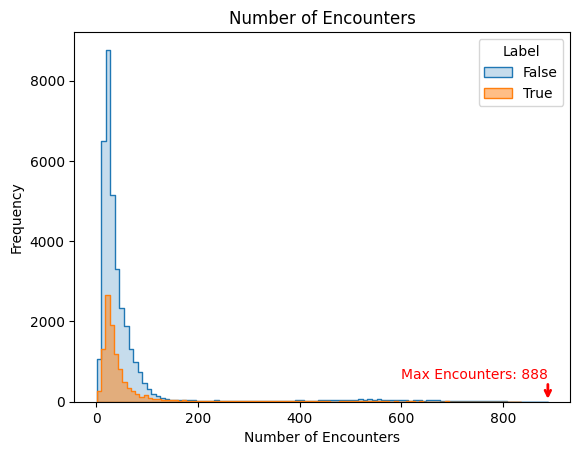

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.histplot(data=df, x='num_encounters', hue='label', element='step', bins=100, palette='pastel')\
sns.histplot(data=df[df['label'] == False], x='num_encounters', label='False', element='step', bins=100, alpha=0.25)
# Plot for label=True with custom opacity
sns.histplot(data=df[df['label'] == True], x='num_encounters', label='True', element='step', bins=100, alpha=0.5)

plt.title('Number of Encounters')
plt.xlabel('Number of Encounters')
plt.ylabel('Frequency')
plt.legend(title='Label')

max_encounters = df['num_encounters'].max()

text_x = max_encounters
text_y = 500
# Add text to the plot
plt.text(x=max_encounters, y=text_y, s=f'Max Encounters: {max_encounters}', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.annotate('', xy=(max_encounters, 0), xytext=(text_x, text_y), arrowprops=dict(arrowstyle='->', lw=2, color='red'))

plt.show()

<Axes: xlabel='num_encounters', ylabel='Count'>

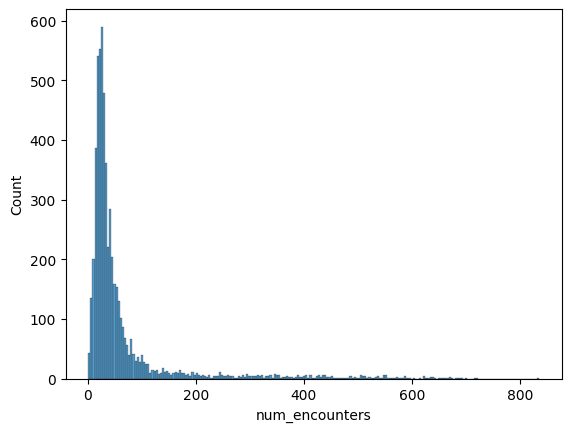

In [47]:
unique_true = df_true.loc[df_true.groupby('patient_id')['num_encounters'].idxmax()]

sns.histplot(data=unique_true, x='num_encounters')

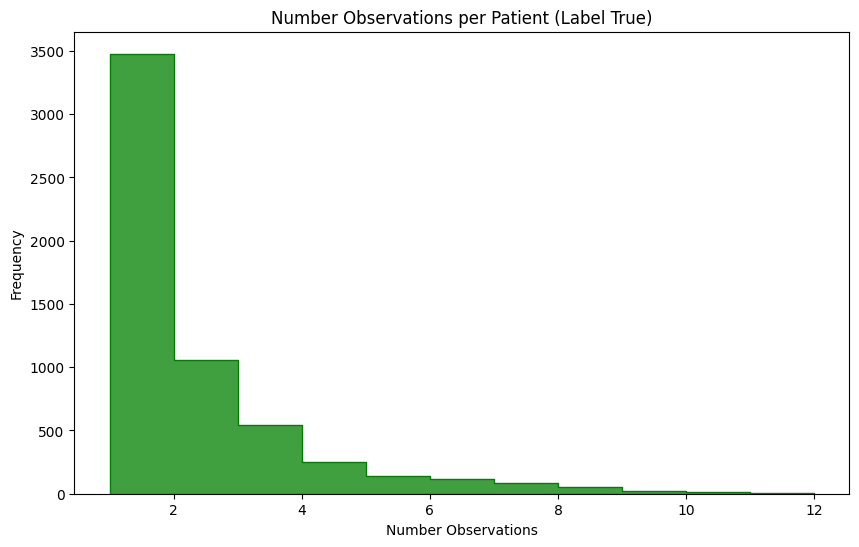

In [52]:
# Filter the DataFrame to only include rows where the label is True
df_true = df[df['label'] == True]

# Group by patient_id and count the number of rows for each patient
df_grouped = df_true.groupby('patient_id').size().reset_index(name='counts')

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(data=df_grouped, x='counts', binwidth=1, color='green', element='step', bins=20)
plt.title('Number Observations per Patient (Label True)')
plt.xlabel('Number Observations')
plt.ylabel('Frequency')
plt.show()

# DL

## FC

In [23]:
model = FC()

logger = CSVLogger("pl_logs_tmp", name="fc")

# Initialize PyTorch Lightning trainer and train the model
trainer = L.Trainer(
    max_epochs=2,
    accelerator="gpu",
    strategy="ddp_notebook",
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss", mode="min", save_last=False, save_top_k=1,
            dirpath="checkpoints_tmp/", filename="fc-{epoch:02d}-{val_mse:.2f}-"
        ),
        EarlyStopping(monitor="val_loss", patience=2, mode="min")
    ],
    logger=logger,
    devices=2,
    log_every_n_steps=5
)

trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kolton.hauck/BMI6114_FinalProject/checkpoints_tmp exists and is not empty.
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name      | Type              | Params
------------------------------------------------
0 | fc1       | Linear            | 98.4 K
1 | fc2       | Linear            | 16.5 K
2 | fc3       | Linear            | 129   
3 | loss_fn   | BCEWithLogits

Epoch 1: 100%|██████████| 166/166 [00:35<00:00,  4.69it/s, v_num=20, train_loss=7.77e-5, train_acc_step=1.000, val_acc_step=1.000, val_loss=0.000163, val_acc_epoch=1.000, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 166/166 [00:35<00:00,  4.69it/s, v_num=20, train_loss=7.77e-5, train_acc_step=1.000, val_acc_step=1.000, val_loss=0.000163, val_acc_epoch=1.000, train_acc_epoch=1.000]


array([[<Axes: >, <Axes: >]], dtype=object)

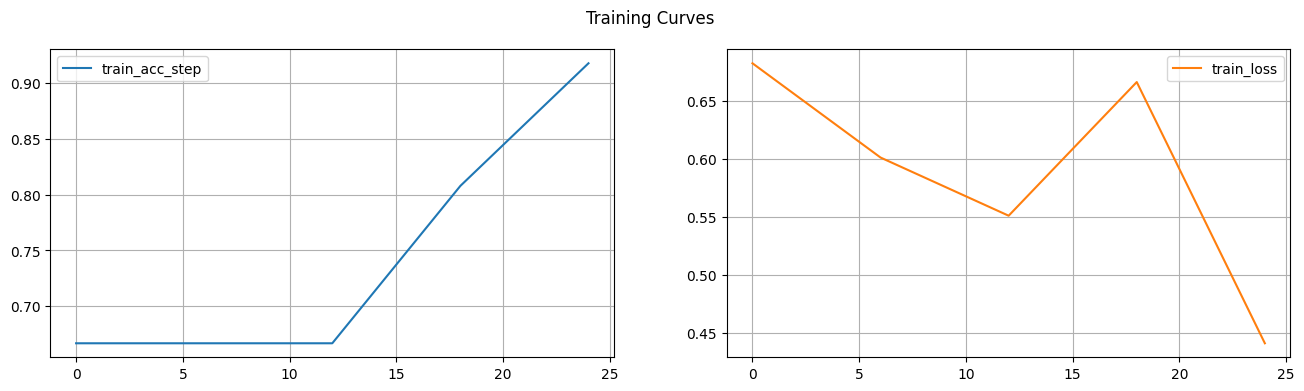

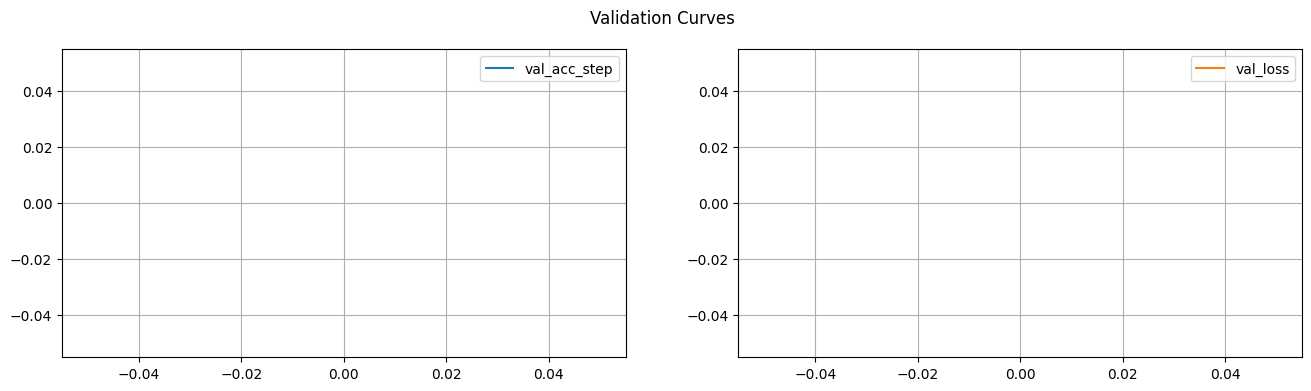

In [20]:
import os
import pandas as pd

num = len(os.listdir("./pl_logs_tmp/fc")) - 1
logs_to_read = f"./pl_logs_tmp/fc/version_{num}/metrics.csv"

hist = pd.read_csv(logs_to_read)
hist[['train_acc_step', 'train_loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Training Curves")
hist[['val_acc_step', 'val_loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Validation Curves")

In [21]:
trainer.test(model, dataloaders=test_dl)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:232: Using `DistributedSampler` with the dataloaders. During `trainer.test()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Otherwise, multi-device settings use `DistributedSampler` that replicates some samples to make sure all devices have same batch size in case of uneven input

Testing DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7584125995635986
        test_loss           0.6024382710456848
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6024382710456848, 'test_acc': 0.7584125995635986}]

## Transformer

In [22]:
model = AttentionModelV2()

logger = CSVLogger("pl_logs_tmp", name="attention")

# Initialize PyTorch Lightning trainer and train the model
trainer = L.Trainer(
    max_epochs=5,
    accelerator="gpu",
    strategy="ddp_notebook",
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss", mode="min", save_last=False, save_top_k=1,
            dirpath="checkpoints_tmp/", filename="attention-{epoch:02d}-{val_mse:.2f}-"
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min")
    ],
    logger=logger,
    devices=2,
    log_every_n_steps=5
)

trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kolton.hauck/BMI6114_FinalProject/checkpoints_tmp exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type              | Params
-------------------------------------------------

Epoch 4: 100%|██████████| 367/367 [01:09<00:00,  5.27it/s, v_num=3, train_loss=0.000, train_acc_step=0.993, val_acc_step=0.994, val_loss=1.27e-6, val_acc_epoch=0.994, train_acc_epoch=0.993]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 367/367 [01:09<00:00,  5.26it/s, v_num=3, train_loss=0.000, train_acc_step=0.993, val_acc_step=0.994, val_loss=1.27e-6, val_acc_epoch=0.994, train_acc_epoch=0.993]


array([[<Axes: >, <Axes: >]], dtype=object)

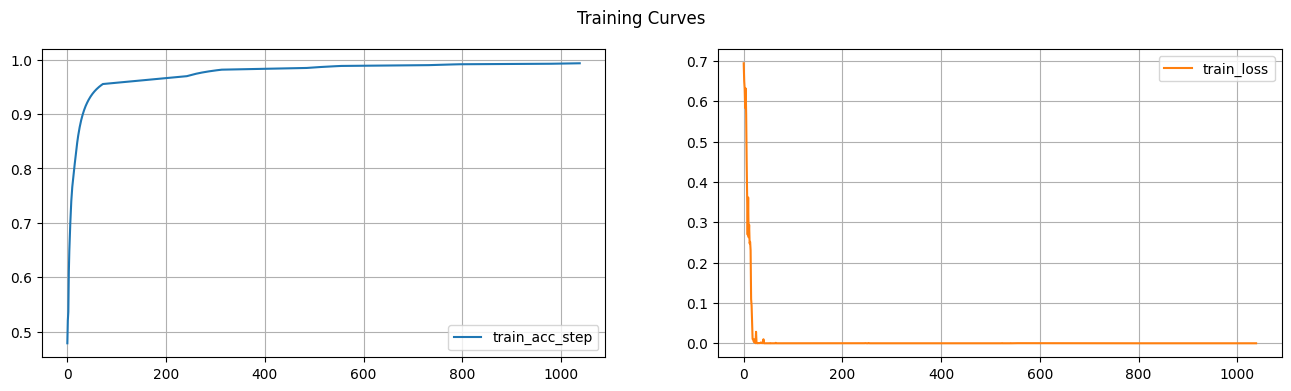

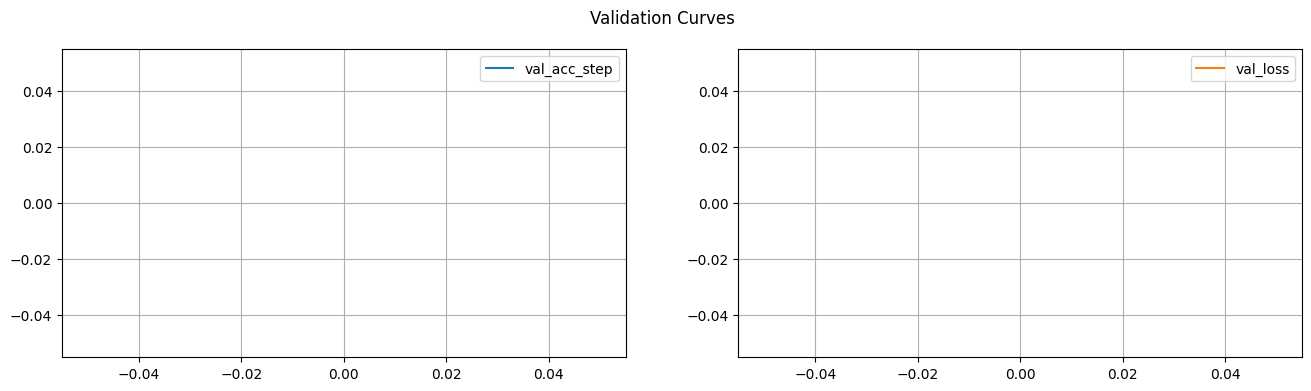

In [25]:
import os
import pandas as pd

num = len(os.listdir("./pl_logs_tmp/attention")) - 1
logs_to_read = f"./pl_logs_tmp/attention/version_{num}/metrics.csv"

hist = pd.read_csv(logs_to_read)
hist[['train_acc_step', 'train_loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Training Curves")
hist[['val_acc_step', 'val_loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Validation Curves")

In [23]:
trainer.test(model, dataloaders=test_dl)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:232: Using `DistributedSampler` with the dataloaders. During `trainer.test()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Otherwise, multi-device settings use `DistributedSampler` that replicates some samples to make sure all devices have same batch size in case of uneven input

Testing DataLoader 0: 100%|██████████| 249/249 [00:18<00:00, 13.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss         2.3526356471847976e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.3526356471847976e-06, 'test_acc': 1.0}]

# ML

## RF

In [27]:
import optuna
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 10, 50, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        
    # Create the RandomForest model with suggested hyperparameters
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                 max_features=max_features, random_state=42)
    
    # Training the model
    clf.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = clf.predict(X_val)
    accuracy = f1_score(y_val, y_pred)
    
    return accuracy  # Return the accuracy as the objective to maximize

# Create a study object
study = optuna.create_study(direction='maximize')
X_train, y_train, X_val, y_val, X_test, y_test, _ = load_data(data, model_type="ml-optuna")

# Execute an optimization
study.optimize(objective, n_trials=10)  # Specify the number of trials

# Fetch the best model
best_params = study.best_params
print("Best parameters:", best_params)
print("Best value (accuracy):", study.best_value)

# Train the final model with best parameters
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train, y_train)  # Assuming train_X and train_y are already loaded and prepared

# Evaluate the final model on the test set
final_predictions = final_model.predict(X_test)
final_accuracy = f1_score(y_test, final_predictions)
print(f"Final test accuracy: {final_accuracy:.2f}")


[I 2024-04-18 20:32:08,925] A new study created in memory with name: no-name-26cd7041-29d2-4d41-8a39-865a85957b4a



        train: 46431
        val: 9949
        test: 9951
        


[I 2024-04-18 20:36:22,960] Trial 0 finished with value: 0.8579615227179697 and parameters: {'n_estimators': 199, 'max_depth': 40, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8579615227179697.
[I 2024-04-18 20:37:55,567] Trial 1 finished with value: 0.8615384615384616 and parameters: {'n_estimators': 180, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8615384615384616.
[I 2024-04-18 20:38:18,252] Trial 2 finished with value: 0.8513761467889909 and parameters: {'n_estimators': 134, 'max_depth': 28, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.8615384615384616.
[I 2024-04-18 21:10:27,806] Trial 3 finished with value: 0.8587044534412955 and parameters: {'n_estimators': 153, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.86153846153846

Best parameters: {'n_estimators': 133, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best value (accuracy): 0.8681025641025641
Final test accuracy: 0.87


In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, final_predictions)

array([[7196,  397],
       [ 249, 2109]])

## Binary Clf

In [29]:
import optuna
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

def objective(trial):
    # Suggest values for the hyperparameters
    C = trial.suggest_float('C', 1e-2, 1e1, log=True)  # Regularization parameter
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'])
    penalty = 'l2'  # Default penalty

    if solver in ['liblinear', 'saga']:
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    # Data Loading (assuming this function is available)
    # train_X, train_y, val_X, val_y, test_X, test_y, _ = load_data(data, model_type="ml-optuna")
    
    # Create the RandomForest model with suggested hyperparameters
    clf = LogisticRegression(C=C, solver=solver, penalty=penalty, random_state=42, max_iter=100)
    
    # Training the model
    clf.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = clf.predict(X_val)
    accuracy = f1_score(y_val, y_pred)
    
    return accuracy  # Return the accuracy as the objective to maximize

# Create a study object
study = optuna.create_study(direction='maximize')
X_train, y_train, X_val, y_val, X_test, y_test, _ = load_data(data, model_type="ml-optuna")

# Execute an optimization
study.optimize(objective, n_trials=10)  # Specify the number of trials

# Fetch the best model
best_params = study.best_params
print("Best parameters:", best_params)
print("Best value (accuracy):", study.best_value)

# Train the final model with best parameters
final_model = LogisticRegression(**best_params)
final_model.fit(X_train, y_train)  # Assuming train_X and train_y are already loaded and prepared

# Evaluate the final model on the test set
final_predictions = final_model.predict(X_test)
final_accuracy = f1_score(y_test, final_predictions)
print(f"Final test accuracy: {final_accuracy:.2f}")


[I 2024-04-19 00:01:05,057] A new study created in memory with name: no-name-2b8d8da0-9a4f-4c3a-a94c-3d6d269d7ec8



        train: 46431
        val: 9949
        test: 9951
        


[I 2024-04-19 00:03:44,346] Trial 0 finished with value: 0.8417391304347827 and parameters: {'C': 0.7913505889292229, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8417391304347827.
[I 2024-04-19 00:03:44,977] Trial 1 finished with value: 0.8702749140893471 and parameters: {'C': 8.666467071521883, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.8702749140893471.
[I 2024-04-19 00:03:45,570] Trial 2 finished with value: 0.8484718037021094 and parameters: {'C': 1.9751164371932004, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.8702749140893471.
[I 2024-04-19 00:03:46,059] Trial 3 finished with value: 0.7613070763903916 and parameters: {'C': 0.025886904718421457, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.8702749140893471.
[I 2024-04-19 00:03:48,661] Trial 4 finished with value: 0.8323826239578762 and parameters: {'C': 0.36406772527248166, 'solver': 'sag'}. Best is trial 1 with value: 0.8702749140893471.
[I 2024-04-19 00:03:49,228] Trial 5 finished with value: 0.8565899

Best parameters: {'C': 8.666467071521883, 'solver': 'newton-cg'}
Best value (accuracy): 0.8702749140893471
Final test accuracy: 0.87


In [30]:
confusion_matrix(y_test, final_predictions)

array([[7335,  278],
       [ 344, 1994]])